## Libraries

In [1]:
## Useful libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
import copy
import pickle
from urllib.request import urlretrieve
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Additional input
import networkx as nx
from tqdm import tqdm
# !pip install torch_geometric
from torch_geometric.data import Data
# !pip install perlin-noise
from perlin_noise import PerlinNoise
import random
from loader import load_dataset


from cycler import cycler
import seaborn as sns
import time

# Set the color scheme
sns.set_theme()
colors = ['#0076C2', '#EC6842', '#A50034', '#009B77', '#FFB81C', '#E03C31', '#6CC24A', '#EF60A3', '#0C2340', '#00B8C8', '#6F1D77']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset
The data folder comprises 4 subfolders (DEM, WD, VX, VY), containing the elevation, water depths in time, and velocities (in x and y directions) in time for all training and testing simulations. The overview.csv file provides the runtime of the numerical model on each different simulation, identified by its id.

- 1-80: Training and validation

- 501-520: Testing dataset 1

- 10001-10020: Testing dataset 2

- 15001-15020: Testing dataset 3

In [2]:
def center_grid_graph(dim1, dim2):
    '''
    Create graph from a rectangular grid of dimensions dim1 x dim2
    Returns networkx graph connecting the grid centers and corresponding 
    node positions
    ------
    dim1: int
        number of grids in the x direction
    dim2: int
        number of grids in the y direction
    '''
    G = nx.grid_2d_graph(dim1, dim2, create_using=nx.DiGraph)
    # for the position, it is assumed that they are located in the centre of each grid
    pos = {i:(x+0.5,y+0.5) for i, (x,y) in enumerate(G.nodes())}
    
    #change keys from (x,y) format to i format
    mapping = dict(zip(G, range(0, G.number_of_nodes())))
    G = nx.relabel_nodes(G, mapping)

    return G, pos

In [3]:
def create_grid_dataset(dataset_folder, n_sim, start_sim=1, number_grids=64):
    '''
    Creates a pytorch geometric dataset with n_sim simulations
    returns a regular grid graph dataset
    ------
    dataset_folder: str, path-like
        path to raw dataset location
    n_sim: int
        number of simulations used in the dataset creation
    '''
    assert os.path.exists(dataset_folder), "There is no raw dataset folder"
    grid_dataset = []

    graph, pos = center_grid_graph(number_grids,number_grids)
    
    for i in tqdm(range(start_sim,start_sim+n_sim)):

        DEM = np.loadtxt(f"{dataset_folder}\\DEM\\DEM_{i}.txt")[:,2]
        WD = np.loadtxt(f"{dataset_folder}\\WD\\WD_{i}.txt")
#         VX = np.loadtxt(f"{dataset_folder}\\VX\\VX_{i}.txt")
#         VY = np.loadtxt(f"{dataset_folder}\\VY\\VY_{i}.txt")
        
        grid_i = convert_to_pyg(graph, pos, DEM, WD)  # VX, VY
        grid_dataset.append(grid_i)
    
    return grid_dataset

In [4]:
def convert_to_pyg(graph, pos, DEM, WD):  # VX, VY
    '''Converts a graph or mesh into a PyTorch Geometric Data type 
    Then, add position, DEM, and water variables to data object'''
    DEM = DEM.reshape(-1)

    edge_index = torch.LongTensor(list(graph.edges)).t().contiguous()
    row, col = edge_index

    data = Data()

    delta_DEM = torch.FloatTensor(DEM[col]-DEM[row])
    coords = torch.FloatTensor(get_coords(pos))
    edge_relative_distance = coords[col] - coords[row]
    edge_distance = torch.norm(edge_relative_distance, dim=1)
    edge_slope = delta_DEM/edge_distance

    data.edge_index = edge_index
    data.edge_distance = edge_distance
    data.edge_slope = edge_slope
    data.edge_relative_distance = edge_relative_distance

    data.num_nodes = graph.number_of_nodes()
    data.pos = torch.tensor(list(pos.values()))
    data.DEM = torch.FloatTensor(DEM)
    data.WD = torch.FloatTensor(WD.T)
#     data.VX = torch.FloatTensor(VX.T)
#     data.VY = torch.FloatTensor(VY.T)
        
    return data

In [5]:
def get_coords(pos):
    '''
    Returns array of dimensions (n_nodes, 2) containing x and y coordinates of each node
    ------
    pos: dict
        keys: (x,y) index of every node
        values: spatial x and y positions of each node
    '''
    return np.array([xy for xy in pos.values()])

In [6]:
def save_database(dataset, name, out_path='datasets'):
    '''
    This function saves the geometric database into a pickle file
    The name of the file is given by the type of graph and number of simulations
    ------
    dataset: list
        list of geometric datasets for grid and mesh
    names: str
        name of saved dataset
    out_path: str, path-like
        output file location
    '''
    n_sim = len(dataset)
    path = f"{out_path}/{name}.pkl"
    
    if os.path.exists(path):
        os.remove(path)
    elif not os.path.exists(out_path):
        os.mkdir(out_path)
    
    pickle.dump(dataset, open(path, "wb" ))
        
    return None

In [7]:
data_folder = 'raw_datasets/'

train_dataset = 'DEM/'

In [8]:
dataset_folder = data_folder
n_sim = 80
start_sim = 1
dataset_name = 'grid'

datasets_folder = 'datasets'
if not os.path.exists(datasets_folder):
    os.makedirs(datasets_folder)
    
dataset_dir = datasets_folder + '/train'


##################### Use this code to create local pickle file #####################
# pyg_dataset = create_grid_dataset(dataset_folder, n_sim=n_sim)
# save_database(pyg_dataset, name=dataset_name, out_path=dataset_dir)

In [9]:
 train_dataset = load_dataset(dataset_name=dataset_name, dataset_folder=dataset_dir)

## Visualization

Start visualization of the data to get a better understanding

In [10]:
print(len(train_dataset))
print(train_dataset[0])
print(type(train_dataset[0]))
print(train_dataset[0].cpu())
print(train_dataset[0]['DEM'])

80
Data(edge_index=[2, 16128], edge_distance=[16128], edge_slope=[16128], edge_relative_distance=[16128, 2], num_nodes=4096, pos=[4096, 2], DEM=[4096], WD=[4096, 97])
<class 'torch_geometric.data.data.Data'>
Data(edge_index=[2, 16128], edge_distance=[16128], edge_slope=[16128], edge_relative_distance=[16128, 2], num_nodes=4096, pos=[4096, 2], DEM=[4096], WD=[4096, 97])
tensor([ 0.0000, -0.4338, -0.9741,  ...,  0.2556,  0.3745,  0.3580])


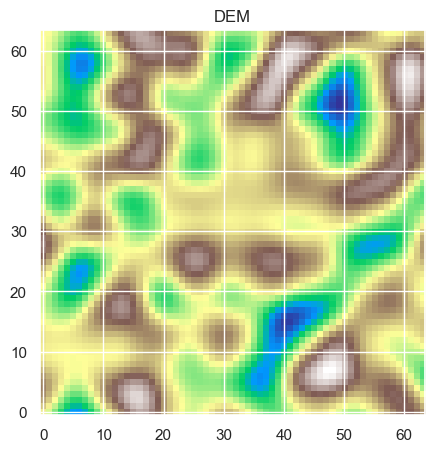

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
number_grids = 64

axs.imshow(train_dataset[0]['DEM'].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
axs.set_title('DEM')

plt.show()
axs.clear()
plt.show()

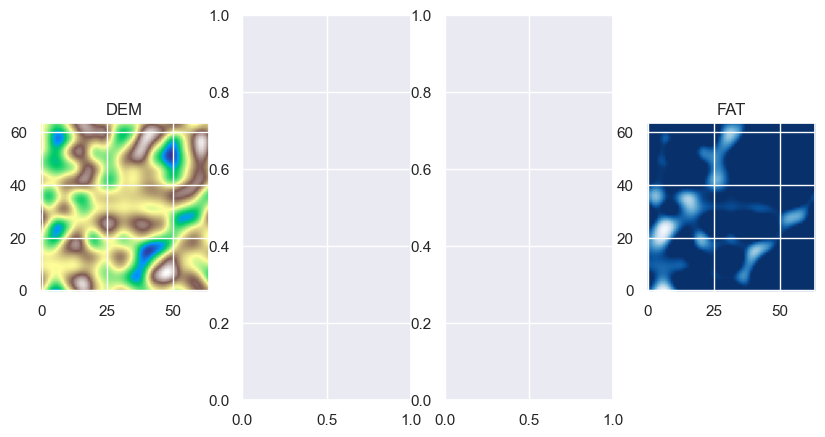

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

axs[0].imshow(train_dataset[0]['DEM'].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

# axs[1].imshow(train_dataset[0]['VX'][:, -1].reshape(number_grids,number_grids), cmap='RdBu', origin='lower')
# axs[1].set_title('Slope X')

# axs[2].imshow(train_dataset[0]['VY'][:, -1].reshape(number_grids,number_grids), cmap='RdBu', origin='lower')
# axs[2].set_title('Slope Y')

axs[3].imshow(train_dataset[0]['WD'][:, -1].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[3].set_title('FAT')
plt.show()

In [13]:
def update(w, s):
    '''
    Function that creates an interactive plot for the four variables
    w: Intslider that adjusts the timestep
    s: Dropdown that adjusts the selected sample
    
    '''
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))
    
    axs[0].set_title('DEM')
    axs[1].set_title('Velocity X')
    axs[2].set_title('Velocity Y')
    axs[3].set_title('FAT')

    axs[0].imshow(train_dataset[s]['DEM'].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
#     axs[1].imshow(train_dataset[s]['VX'][:, w].reshape(number_grids,number_grids).squeeze(), cmap='RdBu', origin='lower')
#     axs[2].imshow(train_dataset[s]['VY'][:, w].reshape(number_grids,number_grids).squeeze(), cmap='RdBu', origin='lower')
    axs[3].imshow(train_dataset[s]['WD'][:, w].reshape(number_grids,number_grids).squeeze(), cmap='Blues_r', origin='lower')
    plt.show()
#     fig.canvas.draw_idle()

interact(update, w=widgets.IntSlider(min=0, max=96, step=1, value=0), s=np.arange(0, n_sim-1));

interactive(children=(IntSlider(value=0, description='w', max=96), Dropdown(description='s', options=(0, 1, 2,…

In [14]:
def _add_colorbar(ax=None, colorbar=True):
    if colorbar:
        self.kwargs['vmax'] = self._check_device(self.kwargs['vmax'])
        self.kwargs['vmin'] = self._check_device(self.kwargs['vmin'])
        if self.difference_plot:
            if self.kwargs['vmin'] >= 0:
                ticks_interval = np.linspace(0, self.kwargs['vmax'], 6, endpoint=True)
                plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=self.kwargs['vmax']), 
                            cmap=self.kwargs['cmap']), ticks=np.sign(ticks_interval)*np.floor(np.abs(ticks_interval)*10)/10,
                            fraction=0.05, shrink=0.9, ax=ax)
            elif self.kwargs['vmax'] <= 0:
                ticks_interval = np.linspace(self.kwargs['vmin'], 0, 6, endpoint=True)
                plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=self.kwargs['vmin'], vmax=0), 
                            cmap=self.kwargs['cmap']), ticks=np.sign(ticks_interval)*np.floor(np.abs(ticks_interval)*10)/10,
                            fraction=0.05, shrink=0.9, ax=ax)
            else:
                ticks_interval = np.linspace(self.kwargs['vmin'], self.kwargs['vmax'], 7, endpoint=True)
                plt.colorbar(plt.cm.ScalarMappable(norm=TwoSlopeNorm(
                            vmin=self.kwargs['vmin'], vcenter=0, vmax=self.kwargs['vmax']), 
                            cmap=self.kwargs['cmap']), ticks=np.sign(ticks_interval)*np.floor(np.abs(ticks_interval)*10)/10,
                            fraction=0.05, shrink=0.9, ax=ax)
        else:
            ticks_interval = np.linspace(self.kwargs['vmin'], self.kwargs['vmax'], 6, endpoint=True)
            plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = self.kwargs['vmin'], vmax=self.kwargs['vmax']), 
                            cmap=self.kwargs['cmap']), ticks=np.sign(ticks_interval)*np.floor(np.abs(ticks_interval)*10)/10,
                            fraction=0.05, shrink=0.9, ax=ax)

### Normalization

Since the input and output values may have very different ranges, it is important to perform normalization to both.

In [15]:
def normalize_dataset(dataset, scaler_DEM, scaler_WD):
    min_DEM, max_DEM = scaler_DEM.data_min_[0], scaler_DEM.data_max_[0]
#     min_VX, max_VX = scaler_VX.data_min_[0], scaler_VX.data_max_[0]
#     min_VY, max_VY = scaler_VY.data_min_[0], scaler_VY.data_max_[0]
    min_WD, max_WD = scaler_WD.data_min_[0], scaler_WD.data_max_[0]
    normalized_dataset = []
    for idx in range(len(dataset)):
        DEM = dataset[idx]['DEM']
#         VX = dataset[idx]['VX']
#         VY = dataset[idx]['VY']
        WD = dataset[idx]['WD']
        norm_DEM = (DEM - min_DEM) / (max_DEM - min_DEM)
#         norm_VX = (VX - min_VX) / (max_VX - min_VX)
#         norm_VY = (VY - min_VY) / (max_VY - min_VY)
        norm_WD = (WD - min_WD) / (max_WD - min_WD)
        normalized_dataset.append((norm_DEM, norm_WD))
    return normalized_dataset

In [16]:
# Normalize the inputs and outputs using training dataset
scaler_DEM = MinMaxScaler() # Can store DEM, VX, VY as one 'input' Scaler
# scaler_VX = MinMaxScaler()
# scaler_VY = MinMaxScaler()
scaler_WD = MinMaxScaler()

for idx in range(len(train_dataset)):
    scaler_DEM.partial_fit(train_dataset[idx]['DEM'].reshape(1, -1).T.cpu())
#     scaler_VX.partial_fit(train_dataset[idx]['VX'].reshape(train_dataset[0]['VX'].shape[0], -1).T.cpu())
#     scaler_VY.partial_fit(train_dataset[idx]['VY'].reshape(train_dataset[0]['VY'].shape[0], -1).T.cpu())
    scaler_WD.partial_fit(train_dataset[idx]['WD'].reshape(1, -1).T.cpu())
    
normalized_train_dataset = normalize_dataset(train_dataset, scaler_DEM, scaler_WD)

In [17]:
# Split dataset into train, validation, and testing
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
training_dataset, val_dataset = random_split(normalized_train_dataset, [train_size, val_size])

In [18]:
# Dataset has two variables, training data DEM, target WD
print('Amount of variables', len(normalized_train_dataset[0]))
print('Size of DEM data', len(normalized_train_dataset[0][0]))
print(f'Size of WD data ({len(normalized_train_dataset[0][1])}, {len(normalized_train_dataset[0][1][0])})')
print(normalized_train_dataset[0][0])

Amount of variables 2
Size of DEM data 4096
Size of WD data (4096, 97)
tensor([0.4818, 0.4313, 0.3685,  ..., 0.5115, 0.5253, 0.5234])
